# **AI and the Future of Work and Learning**

## Objectives

Extract --> Transform --> load 
- File 1: linkedin_job_postings.csv
- File 2: job_skills.csv
- File 3: ai_automation_risk_dataset.csv

Working with 3 files from 2 seperate datsets from kaggle:
1. 1.3M LinkedIn Jobs & Skills 2024 Dataset
2. AI Automation Risk by Job Role Dataset

Due to the large size of the original LinkedIn dataset, a subset of the data was selected and used for this project to ensure manageable processing.

Analyse --> Visulaise --> Hypothesis Testing 
- Hypothesis 1: Human-centred skills and automation risk
- Hypothesis 2: Hybrid digital and domain skills
- Hypothesis 3: Transferable skills and job resilience

Finally export cleaned, transformed data for PowerBI Dashboard and ML Model. 



---

## Extract --> Transform --> Load 

Import Libraries

In [ ]:
import pandas as pd #data processing 
import numpy as np #data processing
import re #cleaning text
import matplotlib.pyplot as plt #visualization
import seaborn as sns #visualization

Extract: Read & Load three CSV files into DataFrames

In [2]:
job_postings = pd.read_csv("../raw_data/linkedin_job_postings-trim.csv")
job_skills   = pd.read_csv("../raw_data/job_skills-trim.csv")
role_attrs   = pd.read_csv("../raw_data/ai_automation_risk_dataset-trim.csv")

Transform Data 

In [ ]:
def normalize_text(s):
    if pd.isna(s):
        return ""
    s = str(s).lower().strip()
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

job_postings["job_link"] = job_postings["job_link"].astype(str).str.strip()
job_postings["job_title_norm"] = job_postings["job_title"].apply(normalize_text)

role_attrs["job_role"] = role_attrs["job_role"].astype(str)
role_attrs["job_role_norm"] = role_attrs["job_role"].apply(normalize_text)

#creates a cleaned version of job titles (job_title_norm)
#creates a cleaned version of job roles (job_role_norm)
#ensures job_link is consistently formatted


In [ ]:
#Mapping job_role from one file with job_title from 2nd csv file. 

role_norm_to_role = dict(
    zip(role_attrs["job_role_norm"], role_attrs["job_role"])
)

def map_role(title_norm):
    if title_norm in role_norm_to_role:
        return role_norm_to_role[title_norm]
    matches = [r for r in role_norm_to_role if r and r in title_norm]
    if matches:
        return role_norm_to_role[max(matches, key=len)]
    return np.nan

job_postings["job_role_mapped"] = job_postings["job_title_norm"].apply(map_role)

In [5]:
#Join job posting with role attributies to enriches each posting with the role-level attributes by joining on the mapped role.
df = job_postings.merge(
    role_attrs.add_prefix("role__"),
    left_on="job_role_mapped",
    right_on="role__job_role",
    how="left"
)

In [6]:
#Remove duplicates 
df_posting = (
    df
    .sort_values("job_link")
    .drop_duplicates("job_link")
    .reset_index(drop=True)
)

print("rows:", len(df_posting))
print("unique job_links:", df_posting["job_link"].nunique())
print("duplicate job_link rate:", df_posting["job_link"].duplicated().mean())

rows: 50015
unique job_links: 50015
duplicate job_link rate: 0.0


---

## Feature Engineering 

In [7]:
#Create a human centred index 
for c in [
    "role__communication_requirement",
    "role__social_interaction_level",
    "role__team_collaboration_level",
    "role__creativity_requirement"
]:
    df_posting[c] = pd.to_numeric(df_posting[c], errors="coerce")

def minmax(s):
    s = s.astype(float)
    if s.min() == s.max():
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - s.min()) / (s.max() - s.min())

df_posting["comm_n"]   = minmax(df_posting["role__communication_requirement"])
df_posting["social_n"] = minmax(df_posting["role__social_interaction_level"])
df_posting["team_n"]   = minmax(df_posting["role__team_collaboration_level"])
df_posting["crea_n"]   = minmax(df_posting["role__creativity_requirement"])

df_posting["human_centred_index"] = df_posting[
    ["comm_n","social_n","team_n","crea_n"]
].mean(axis=1)

In [8]:
#Main data fields are numeric for analysis
df_posting["automation_risk_score"] = pd.to_numeric(
    df_posting["role__automation_risk_score"], errors="coerce"
)

df_posting["job_growth_rate"] = pd.to_numeric(
    df_posting["role__job_growth_rate"], errors="coerce"
)

df_posting["role__domain_specific_knowledge_level"] = pd.to_numeric(
    df_posting["role__domain_specific_knowledge_level"], errors="coerce"
)

df_posting["role__ai_dependency_current"] = pd.to_numeric(
    df_posting["role__ai_dependency_current"], errors="coerce"
)

Descriptive statistics - Check on how the data looks 

In [9]:
df_posting[[
    "human_centred_index",
    "automation_risk_score",
    "role__domain_specific_knowledge_level",
    "role__ai_dependency_current",
    "job_growth_rate"
]].describe()

,human_centred_index,automation_risk_score,role__domain_specific_knowledge_level,role__ai_dependency_current,job_growth_rate
count,7215.000000,7215.000000,7215.000000,7215.000000,7215.000000
mean,0.498504,0.491497,0.507492,0.495440,0.016578
std,0.141405,0.268652,0.269642,0.285967,0.073386
min,0.104962,0.000739,0.000129,0.001560,-0.099897
25%,0.407729,0.263281,0.284090,0.242065,-0.045716
50%,0.492405,0.486839,0.524114,0.490061,0.017581
75%,0.588832,0.700187,0.716658,0.750867,0.071948
max,0.949171,0.997805,0.999862,0.999107,0.149902


Distribution Plots - Look for any outliers or skewness 

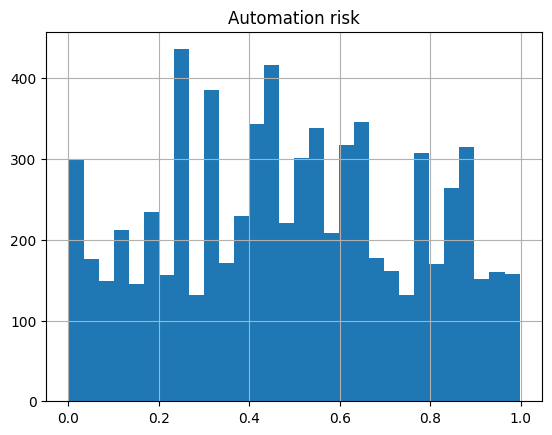

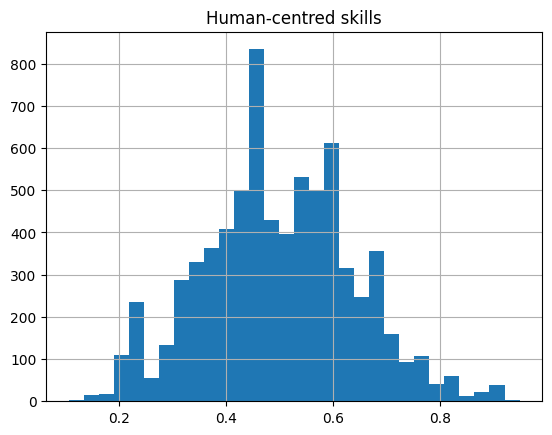

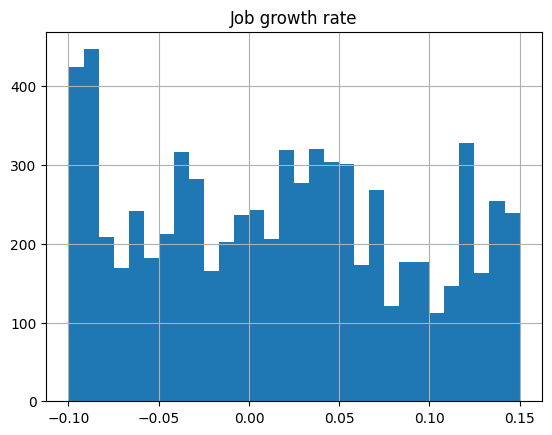

In [10]:
df_posting["automation_risk_score"].hist(bins=30)
plt.title("Automation risk")
plt.show()

df_posting["human_centred_index"].hist(bins=30)
plt.title("Human-centred skills")
plt.show()

df_posting["job_growth_rate"].hist(bins=30)
plt.title("Job growth rate")
plt.show()

Correlation Matrix and Heatmap - Check the relationships

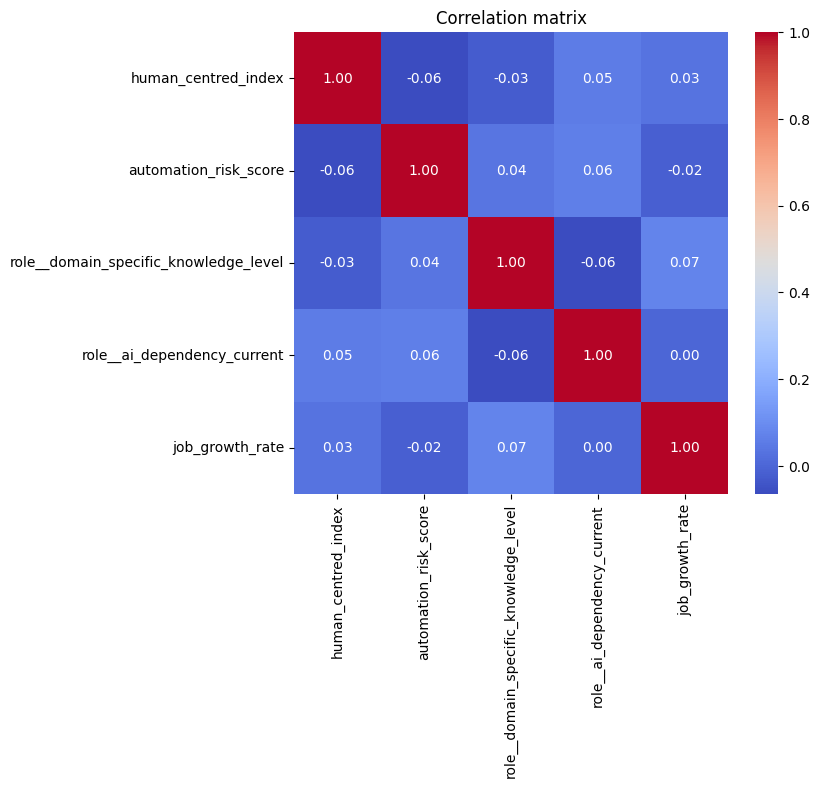

In [11]:
corr_vars = df_posting[[
    "human_centred_index",
    "automation_risk_score",
    "role__domain_specific_knowledge_level",
    "role__ai_dependency_current",
    "job_growth_rate"
]]

corr = corr_vars.corr()

plt.figure(figsize=(7,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix")
plt.show()

## Hypothesis Testing 

### Hypothesis 1: Human-centred skills and automation risk

Job roles that require more human-centred skills (such as communication, creativity and problem-solving) have lower automation risk than roles based mainly on routine or repetitive tasks.


In [12]:
h1_df = df_posting.dropna(
    subset=["human_centred_index","automation_risk_score"]
)

h1_corr = h1_df["human_centred_index"].corr(
    h1_df["automation_risk_score"]
)

print("H1 correlation:", h1_corr)
print("H1 sample size:", len(h1_df))

H1 correlation: -0.06411290006875454
H1 sample size: 7215


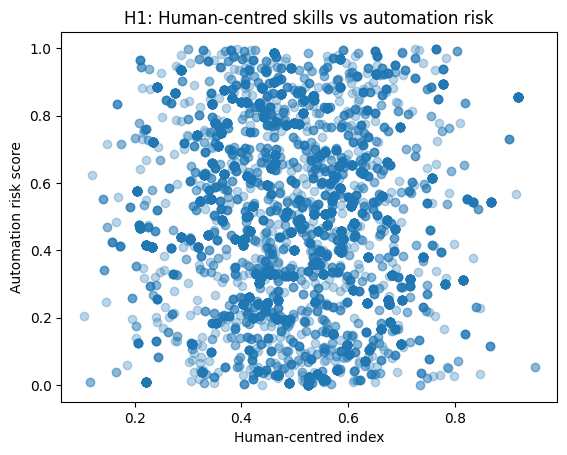

In [13]:
plt.scatter(
    df_posting["human_centred_index"],
    df_posting["automation_risk_score"],
    alpha=0.3
)
plt.xlabel("Human-centred index")
plt.ylabel("Automation risk score")
plt.title("H1: Human-centred skills vs automation risk")
plt.show()

### Hypothesis 2: Hybrid digital and domain skills

Job roles that combine digital or AI skills with domain knowledge (such as healthcare, business, education or engineering) are growing faster than roles that require only technical skills or only non-technical skills.


In [14]:
role_level = (
    df_posting
    .dropna(subset=[
        "job_role_mapped",
        "job_growth_rate",
        "role__domain_specific_knowledge_level",
        "role__ai_dependency_current"
    ])
    .groupby("job_role_mapped", as_index=False)
    .agg(
        job_growth_rate=("job_growth_rate","first"),
        domain_level=("role__domain_specific_knowledge_level","first"),
        ai_dependency=("role__ai_dependency_current","first")
    )
)

In [15]:
domain_thr = role_level["domain_level"].median()
ai_thr     = role_level["ai_dependency"].median()

role_level["hybrid_role_flag"] = (
    (role_level["domain_level"] >= domain_thr) &
    (role_level["ai_dependency"] >= ai_thr)
).astype(int)

print(role_level["hybrid_role_flag"].value_counts())

hybrid_role_flag
0    16
1     4
Name: count, dtype: int64


In [16]:
g = role_level.groupby("hybrid_role_flag")["job_growth_rate"].mean()

print("Mean growth by role type:")
print(g)
print("Difference (hybrid - non-hybrid):",
      g.get(1, np.nan) - g.get(0, np.nan))

Mean growth by role type:
hybrid_role_flag
0    0.042626
1    0.073219
Name: job_growth_rate, dtype: float64
Difference (hybrid - non-hybrid): 0.030592915328350935


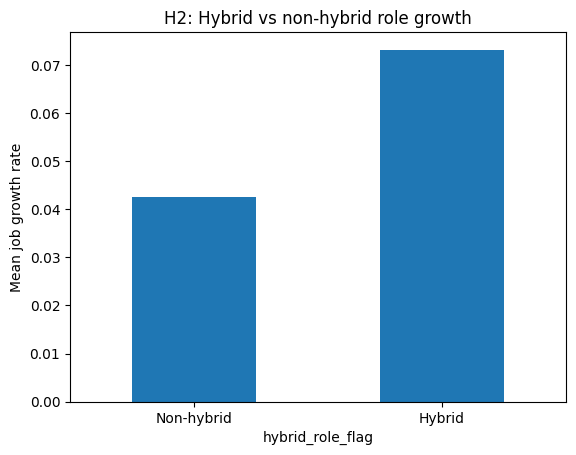

In [18]:
role_level.groupby("hybrid_role_flag")["job_growth_rate"].mean().plot(kind="bar")
plt.xticks([0,1],["Non-hybrid","Hybrid"],rotation=0)
plt.ylabel("Mean job growth rate")
plt.title("H2: Hybrid vs non-hybrid role growth")
plt.show()

### Hypothesis 3: Transferable skills and job resilience

Job roles that require a wider mix of skills (technical, human and business skills) are less vulnerable to automation than roles with a narrow and highly specialised skill set.

In [19]:
candidate_cols = [
    "skill_count",
    "human_skill_count",
    "tech_skill_count",
    "business_skill_count",
    "skill_bucket_breadth"
]

existing = [c for c in candidate_cols if c in df_posting.columns]
print("Existing skill columns:", existing)

for c in existing:
    print("\n", c)
    print(df_posting[c].value_counts(dropna=False).head())

Existing skill columns: []


In [20]:
if "skill_bucket_breadth" in df_posting.columns and df_posting["skill_bucket_breadth"].nunique() > 1:
    print("H3 can be tested.")
else:
    print("H3 cannot be tested: no valid transferable skill breadth signal.")

H3 cannot be tested: no valid transferable skill breadth signal.


---

Export Dataset for ML & Dashboard 

In [22]:
import os

# create the folder (if it does not already exist)
os.makedirs("../processed_data", exist_ok=True)

# save dashboard dataset
df_posting.to_csv("../processed_data/powerbi_dataset.csv", index=False)

# save ML dataset
ml_dataset = df_posting[[
    "human_centred_index",
    "role__ai_dependency_current",
    "role__domain_specific_knowledge_level",
    "automation_risk_score",
    "job_growth_rate"
]]

ml_dataset.to_csv("../processed_data/ml_dataset.csv", index=False)

print("Saved files in ../processed_data/")

Saved files in ../processed_data/
